# Introduction


**What?** PIs via XGBoost Gradient Boosting with Quantile Loss Function on Boston Housing dataset


**Reference:** Jiang, Yingying, Fuming Lin, and Yong Zhou. "The k th power expectile regression." Annals of the Institute of Statistical Mathematics (2019): 1-31.<br>
**NOTE**: I did not manage to make it work for the Boston housing dataset!<br>



# Import modules

In [2]:
import numpy as np
import pandas as pd
from math import e
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_pinball_loss
from statistics import stdev
from matplotlib import rcParams
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import datasets, ensemble
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import make_scorer
from xgboost import XGBRegressor
from pprint import pprint
rcParams['figure.figsize'] = 25, 8
rcParams['font.size'] = 25

# Helper functions

In [3]:
def report(results, n_top = 1):
    """
    Report the first n_top CV results.
    """
    for i in range(1, n_top + 1):
        print(i)
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print(candidate)
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.9f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            
    return np.flatnonzero(results['rank_test_score'] == 1)[0]

In [4]:
# https://gist.github.com/Nikolay-Lysenko/06769d701c1d9c9acb9a66f2f9d7a6c7
def log_cosh_quantile(alpha):
    """
    LogCosh quantile is nothing more than a smooth quantile loss function.
    This funciotion is C^oo so C1 and C2 which is all we need.
    """
    def _log_cosh_quantile(y_true, y_pred):
        err = (y_pred - y_true)
        err = np.where(err < 0, alpha * err, (1 - alpha) * err)
                
        grad = np.tanh(err)          
        hess = 1 / np.cosh(err)**2
            
        return grad, hess
    
    return _log_cosh_quantile

In [34]:
p = 1.
def kth_expectile(alpha):
    """    
    """
    def _kth_expectile(y_true, y_pred):
        x = (y_pred - y_true)
        grad = np.where(x < 0, -alpha *p* abs(x)**(p-1), (1 - alpha ) *p* abs(x)**(p-1))
        hess = np.where(x < 0, -alpha *p* (p-1)*abs(x)**(p-2), (1 - alpha ) *p* (p-1)*abs(x)**(p-2))        
        return grad, hess
    
    return _kth_expectile

# Visual check

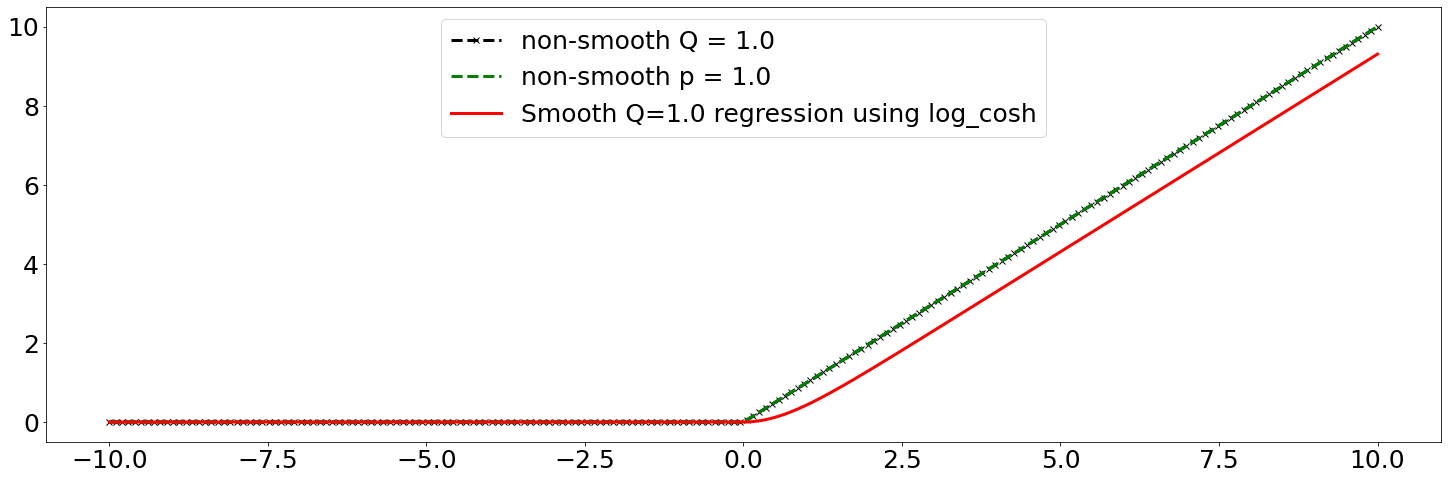

In [35]:
x = np.linspace(-10, 10, 200)
y = np.abs(x)
alpha = 1.0
y_Q = np.where(x >= 0, alpha * abs(x), (1 - alpha ) * abs(x))
y_p = np.where(x >= 0, alpha * abs(x)**p, (1 - alpha ) * abs(x)**p)

y_logcosh = np.where(x >= 0, alpha * np.log(np.cosh(x)), (1 - alpha) * np.log(np.cosh(x)))
#y_p_ower = np.where(x >= 0, alpha * abs(x)**p, (1 - alpha) * abs(x)**p)

plt.plot(x, y_Q, "kx--", lw = 3, label = 'non-smooth Q = ' + str(alpha))
plt.plot(x, y_p, "g--", lw = 3, label = 'non-smooth p = ' + str(alpha))
plt.plot(x, y_logcosh, "r-", lw = 3, label = "Smooth Q=" + str(alpha) + " regression using log_cosh")

plt.legend(loc = "upper center")
plt.show()

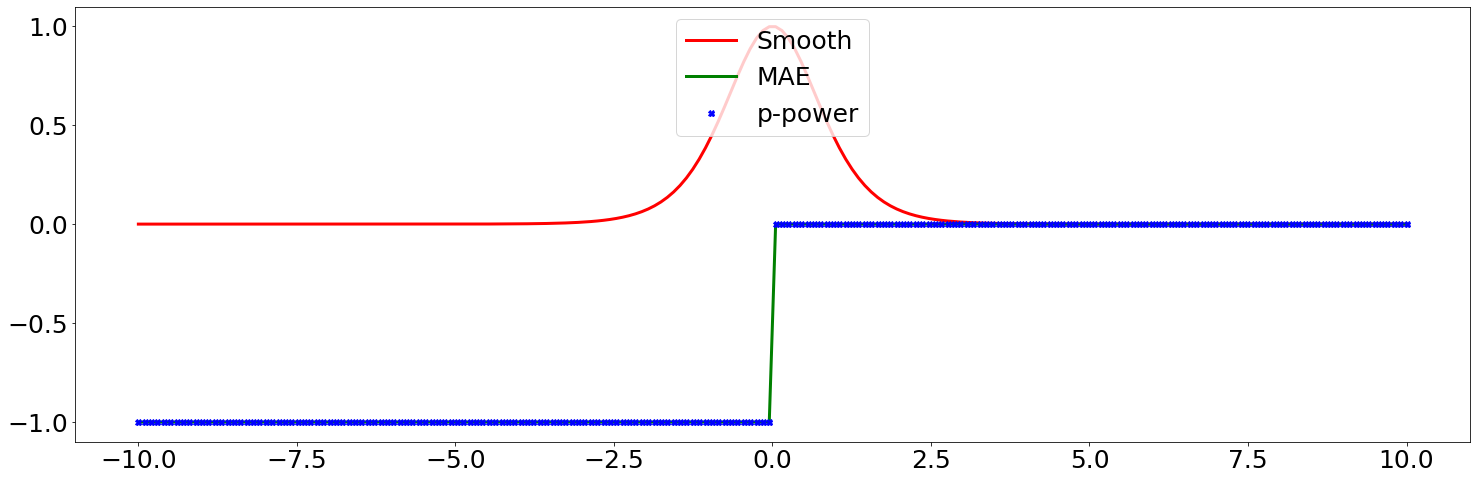

In [36]:
x = np.linspace(-10, 10, 200)
y = np.abs(x)
y_Q = np.where(x < 0, alpha * abs(x), (1 - alpha ) * abs(x))
y_Q_prime = np.where(x < 0, -alpha, 1 - alpha)

y_p = np.where(x < 0, alpha * abs(x)**p, (1 - alpha ) * abs(x)**p)
y_pp = np.where(x < 0, -alpha *p*abs(x)**(p-1), (1 - alpha)*p* abs(x)**(p-1))


y_logcosh = np.where(x < 0, alpha * np.log(np.cosh(x)), (1 - alpha) * np.log(np.cosh(x)))
y_logcosh_sec = grad = 1 / np.cosh(x)**2     


plt.plot(x, y_logcosh_sec, "r-", lw = 3, label = "Smooth")
plt.plot(x, y_Q_prime, "g-", lw = 3, label = "MAE")
plt.plot(x, y_pp, "bX", lw = 3, label = "p-power")

plt.legend(loc = "upper center")
plt.show()

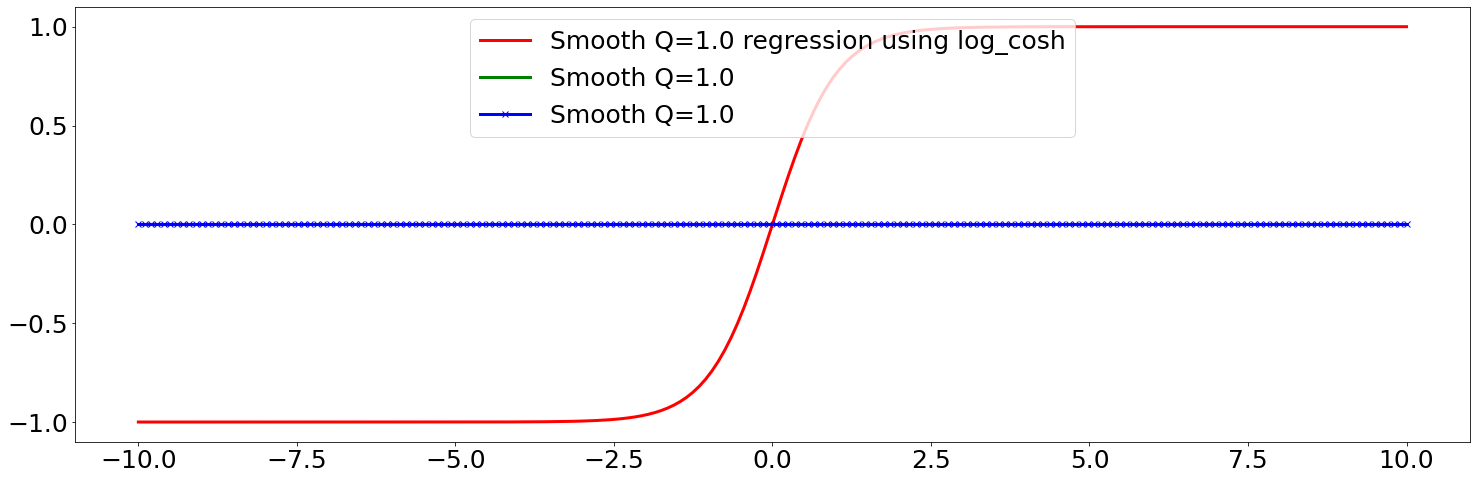

In [37]:
x = np.linspace(-10, 10, 200)
y = np.abs(x)
y_Q = np.where(x < 0, alpha * abs(x), (1 - alpha ) * abs(x))
y_Q_prime = np.where(x < 0, 0, 0)

y_p = np.where(x < 0, alpha * abs(x)**p, (1 - alpha ) * abs(x)**p)
y_pp = np.where(x < 0, -alpha *p* abs(x)**(p-1), (1 - alpha ) *p* abs(x)**(p-1))
y_ppp = np.where(x < 0, alpha *p* (p-1)*abs(x)**(p-2), (1 - alpha ) *p* (p-1)*abs(x)**(p-2))

y_logcosh = np.where(x < 0, alpha * np.log(np.cosh(x)), (1 - alpha) * np.log(np.cosh(x)))
y_logcosh_prime = grad = np.tanh(x)          


plt.plot(x, y_logcosh_prime, "r-", lw = 3, label = "Smooth Q=" + str(alpha) + " regression using log_cosh")
plt.plot(x, y_Q_prime, "g-", lw = 3, label = "Smooth Q=" + str(alpha))
plt.plot(x, y_ppp, "bx-", lw = 3, label = "Smooth Q=" + str(alpha))

plt.legend(loc = "upper center")
plt.show()

# Dataset


- Let’s look at the well-known **Boston housing** dataset and try to create prediction intervals
- We’ll use 400 samples for training, leaving 106 samples for test. 



In [38]:
boston = load_boston()
x_df = pd.DataFrame(boston.data, columns = boston.feature_names)

In [39]:
y_df = pd.DataFrame(boston.target, columns = ['Target'])

In [40]:
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, 
                                                    test_size=.2,
                                                    shuffle=True, 
                                                    random_state=7)

In [41]:
# This is essentially the validation set
x_train2, x_test2, y_train2, y_test2 = \
train_test_split(X_train, y_train, test_size=.2, random_state=7, shuffle=True)
print(len(x_train2))
print(len(X_train))

323
404


In [42]:
y_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102 entries, 357 to 26
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Target  102 non-null    float64
dtypes: float64(1)
memory usage: 1.6 KB


# Modelling + no tuning


- PIs with the Gradient Boosting Regressor. GB builds an additive model in a forward stage-wise 
fashion; it allows for the optimization of arbitrary differentiable loss functions. In each stage a regression tree
is fit on the negative gradient of the given loss function. We'll fit 3 models:
    - One for the **lower prediction**
    - One for the **upper prediction**
    - One for the **mid prediction** which predicts the mean. This what is done all the time.
      
- **IMPORTANT**: when we change the loss to quantile and choose alpha (the quantile), we’re able to get predictions 
corresponding to percentiles. If we use lower and upper quantiles, we can produce an estimated range which is exactly 
what we want. 
- **CL** stands for confidence level which is neither CI or PI.



In [43]:
# Confidence Level
CL = 0.90
alphaUpper = CL + (1 - CL)/2
alphaLower= (1 - CL)/2
print(alphaUpper*100, alphaLower*100)

95.0 4.999999999999999



- Reference on how to create a custom-made **evaluation_metric** in XGBoost: https://coderzcolumn.com/tutorials/machine-learning/xgboost-an-in-depth-guide-python
- Reference on how the **pin ball loss fnction** works in sklearn: https://scikit-learn.org/dev/modules/generated/sklearn.metrics.mean_pinball_loss.html        



In [44]:
# https://gist.github.com/Nikolay-Lysenko/06769d701c1d9c9acb9a66f2f9d7a6c7
def log_cosh_quantile_loss(y_true, y_pred, alpha):

    err = (y_pred - y_true)
    #err = np.where(err < 0, alpha * err, (1 - alpha) * err)    
    err = np.where(err < 0, alpha * np.log(np.cosh(err)), (1 - alpha) * np.log(np.cosh(err)))
    
    loss = np.mean(err)
    
    return loss

In [45]:
def kth_expectile_loss(y_true, y_pred, alpha):
    """    
    """

    x = (y_pred - y_true)
    err = np.where(x >= 0, alpha * abs(x)**p, (1 - alpha ) * abs(x)**p)
    loss = np.mean(err)
    
    return loss

In [46]:
def meanPinBallLossLower(preds, dmat):
    """
    Custom-made mean pin Ball loss
    y_true = [1, 2, 3]
    mean_pinball_loss(y_true, [0, 2, 3], alpha=0.1)
    which retunrs 0.033333333
    """
        
    targets = dmat.get_label()    
    #loss = log_cosh_quantile_loss(targets, preds, alpha = alphaLower)
    loss = kth_expectile_loss(targets, preds, alpha = alphaLower)
    
    return "PinBallLoss", loss

def meanPinBallLossUpper(preds, dmat):
    """
    Custom-made mean pin Ball loss
    y_true = [1, 2, 3]
    mean_pinball_loss(y_true, [0, 2, 3], alpha=0.1)
    which retunrs 0.033333333
    """
        
    targets = dmat.get_label()    
    
    #loss = log_cosh_quantile_loss(targets, preds, alpha = alphaLower)
    loss = kth_expectile_loss(targets, preds, alpha = alphaUpper)
    #print(loss)
    #loss = mean_pinball_loss(targets, preds, alpha = alphaUpper)
    #print(loss)
    #stop
    
    return "PinBallLoss", loss


- There are 3 sets: training, test and validation.
- Validation set is further out from the training set, in this way we leave the test set absolutely unseen.
- Why is it necessary we use the validation test label with **_2** while training? Because during this process the model is assesed via some test set.
- Where do we take this test set? We could use the original one, but in this way we'd be passing (even if implicitly) some info to the model.
- So instead to further split the training set in another train and test set (tagged as _2) to avoid this implicit data leakage.
    


In [47]:
# upper percentile
#modelUp = XGBRegressor(objective=log_cosh_quantile(alphaUpper))
modelUp = XGBRegressor(objective=kth_expectile(alphaUpper))
modelUp.fit(x_train2, y_train2,
            eval_set = [(x_train2, y_train2), (x_test2, y_test2)],
            eval_metric = meanPinBallLossUpper,            
            verbose = False,
            early_stopping_rounds = 50)
resultsUp = modelUp.evals_result()

# lower percentile
#modelLow = XGBRegressor(objective=log_cosh_quantile(alphaLower))
modelLow = XGBRegressor(objective=kth_expectile(alphaLower),
                       learning_rate = 2)
modelLow.fit(x_train2, y_train2,
             eval_set = [(x_train2, y_train2), (x_test2, y_test2)],             
             eval_metric = meanPinBallLossLower,             
             verbose = False)
resultsLow = modelLow.evals_result()

# prediction
modelMid = XGBRegressor()
modelMid.fit(x_train2, y_train2, 
             eval_set=[(x_train2, y_train2), (x_test2, y_test2)],
             eval_metric = "rmse",             
             verbose = False)
resultsMid = modelMid.evals_result()

[14:54:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:54:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:54:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


<ipython-input-34-701cf3d50f43>:8: RuntimeWarning: divide by zero encountered in reciprocal
  hess = np.where(x < 0, -alpha *p* (p-1)*abs(x)**(p-2), (1 - alpha ) *p* (p-1)*abs(x)**(p-2))
<ipython-input-34-701cf3d50f43>:8: RuntimeWarning: invalid value encountered in multiply
  hess = np.where(x < 0, -alpha *p* (p-1)*abs(x)**(p-2), (1 - alpha ) *p* (p-1)*abs(x)**(p-2))


In [48]:
preds = modelMid.predict(X_train)

r2_s = r2_score(y_train, preds)
mse = mean_squared_error(y_train, preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_train, preds)

print("MidModel [MSE]_train80%: ", mse)
print("MidModel [RMSE]_train80%: ", rmse)
print("MidModel [MAE]_train80%: ", mae)
print("MidModel [R2]_train80%: ", r2_s)

MidModel [MSE]_train80%:  3.2345659648455993
MidModel [RMSE]_train80%:  1.7984899123558074
MidModel [MAE]_train80%:  1.2535400286759482
MidModel [R2]_train80%:  0.962094026678505


In [49]:
preds = modelMid.predict(X_test)

r2_s = r2_score(y_test, preds)
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, preds)

print("MidModel [MSE]_test20%: ", mse)
print("MidModel [RMSE]_test20%: ", rmse)
print("MidModel [MAE]_test20%: ", mae)
print("MidModel [R2]_test20%: ", r2_s)

MidModel [MSE]_test20%:  14.593641896946705
MidModel [RMSE]_test20%:  3.820162548497996
MidModel [MAE]_test20%:  2.3421084759282134
MidModel [R2]_test20%:  0.8193996123532717


## Plotting learning with no-cross validation


- TBC



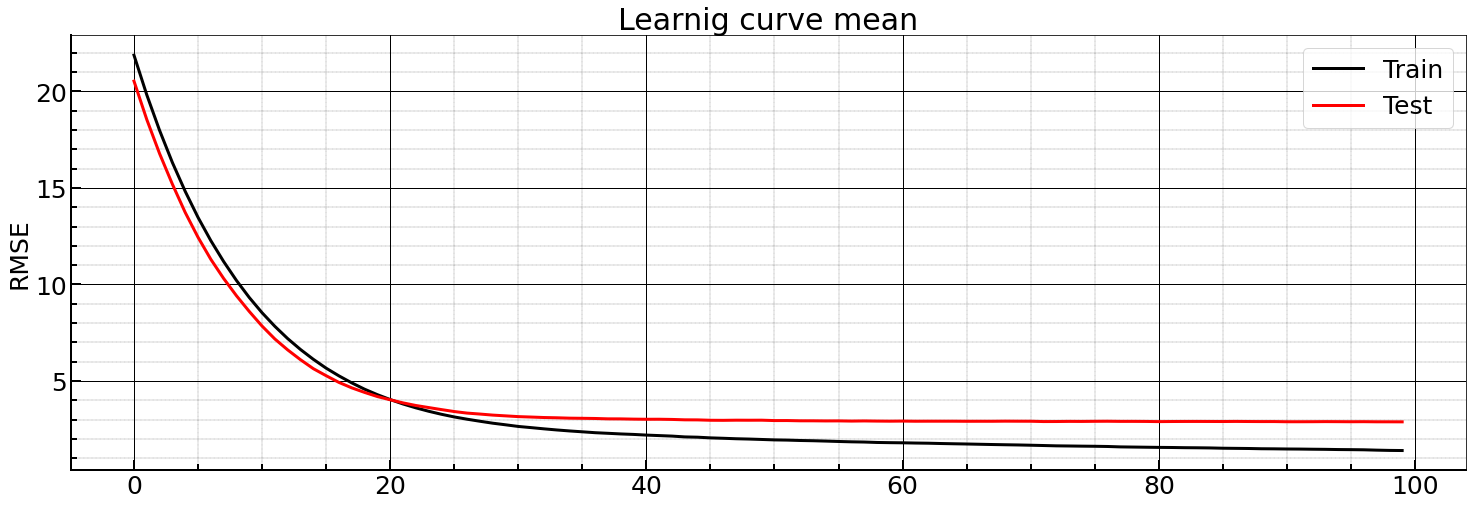

In [50]:
# plot classification error
fig, ax = plt.subplots()
epochs = len(resultsMid['validation_0']['rmse'])
x_axis = range(0, epochs)
ax.plot(x_axis, resultsMid['validation_0']['rmse'], "k-", lw = 3, label = 'Train')
ax.plot(x_axis, resultsMid['validation_1']['rmse'], "r-", lw = 3, label = 'Test')
ax.legend()
plt.ylabel('RMSE')
plt.title('Learnig curve mean')

ax.grid(which = "major", linestyle='-', linewidth='1.0', color='k')
ax.grid(which = "minor", linestyle='--', linewidth='0.25', color='k')
ax.tick_params(which = 'major', direction='in', length=10, width=2)
ax.tick_params(which = 'minor', direction='in', length=6, width=2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.minorticks_on()
    
plt.show()

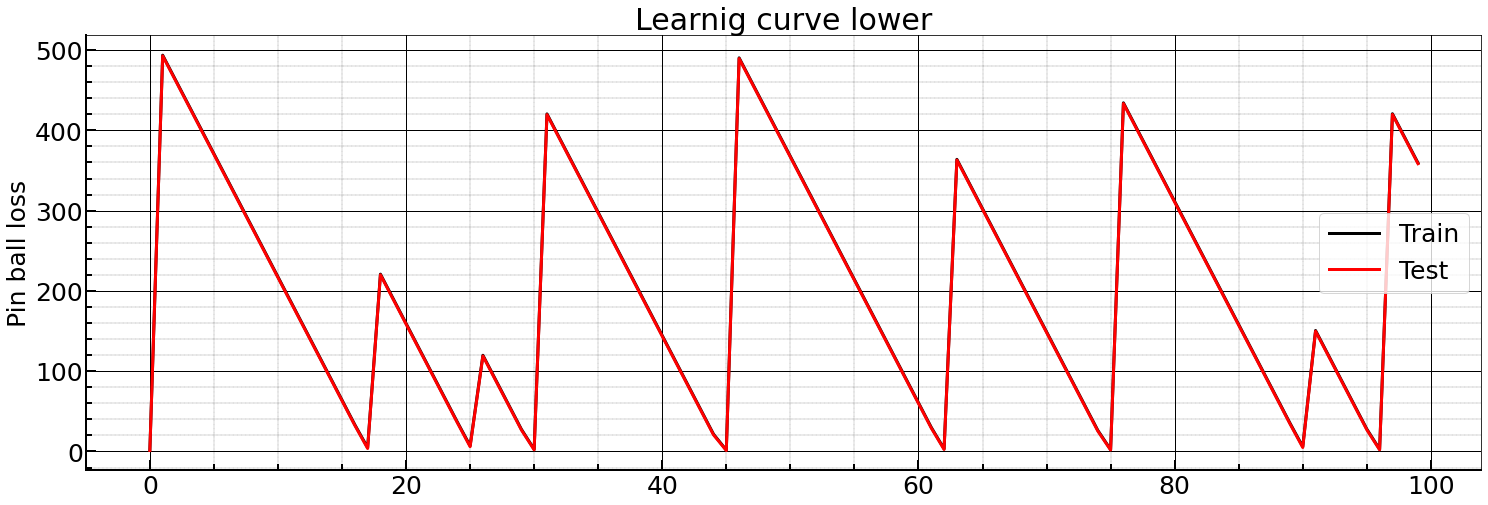

In [51]:
# plot classification error
fig, ax = plt.subplots()
epochs = len(resultsLow['validation_0']['PinBallLoss'])
x_axis = range(0, epochs)
ax.plot(x_axis, resultsLow['validation_0']['PinBallLoss'], "k-", lw = 3, label = 'Train')
ax.plot(x_axis, resultsLow['validation_1']['PinBallLoss'], "r-", lw = 3, label = 'Test')
ax.legend()
plt.ylabel('Pin ball loss')
plt.title('Learnig curve lower')

ax.grid(which = "major", linestyle='-', linewidth='1.0', color='k')
ax.grid(which = "minor", linestyle='--', linewidth='0.25', color='k')
ax.tick_params(which = 'major', direction='in', length=10, width=2)
ax.tick_params(which = 'minor', direction='in', length=6, width=2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.minorticks_on()

plt.show()

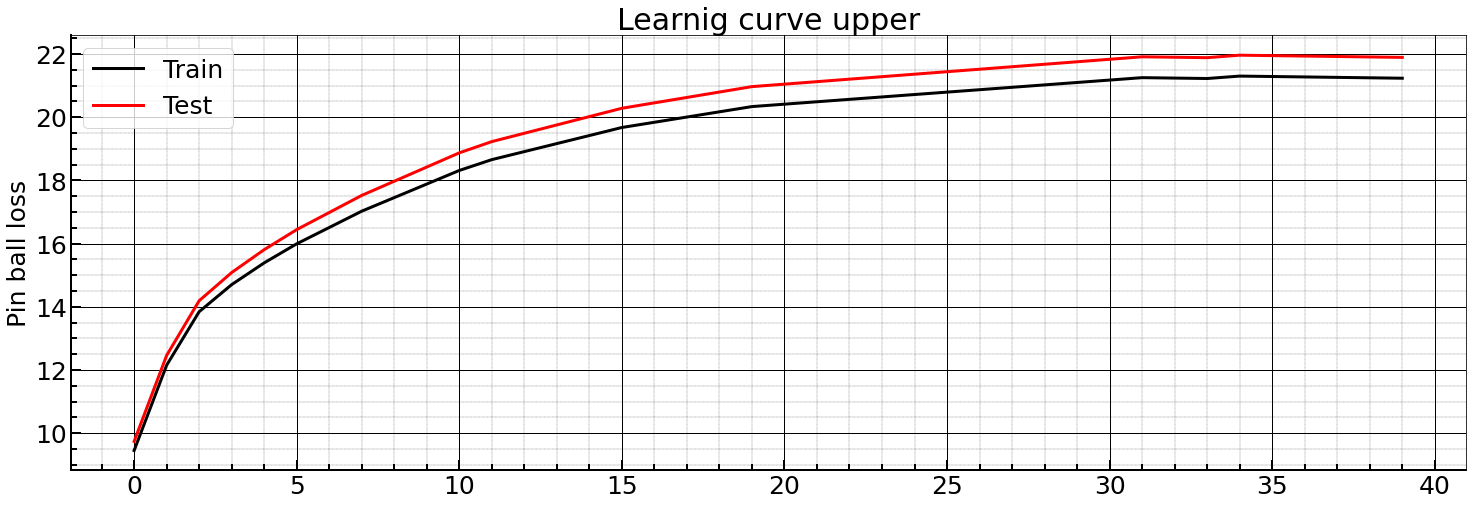

In [52]:
# plot classification error
fig, ax = plt.subplots()
epochs = len(resultsUp['validation_0']['PinBallLoss'])
x_axis = range(0, epochs)
ax.plot(x_axis, resultsUp['validation_0']['PinBallLoss'], "k-", lw = 3, label = 'Train')
ax.plot(x_axis, resultsUp['validation_1']['PinBallLoss'], "r-", lw = 3, label = 'Test')
ax.legend()
plt.ylabel('Pin ball loss')
plt.title('Learnig curve upper')

ax.grid(which = "major", linestyle='-', linewidth='1.0', color='k')
ax.grid(which = "minor", linestyle='--', linewidth='0.25', color='k')
ax.tick_params(which = 'major', direction='in', length=10, width=2)
ax.tick_params(which = 'minor', direction='in', length=6, width=2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.minorticks_on()

plt.show()

# Make predictions


- With the models all trained, we now make predictions and record them with the true values.
- We also adding the prediction obtained tuning the model, because we wanted to verify if the lack of tuning was causing some issue.



In [53]:
predictions = pd.DataFrame()
predictions["ID"] = np.arange(len(X_test))
predictions['truth'] = [i[0] for i in y_test.values.tolist()]


#predictions['lower_tuned'] = lower_model_tuned.predict(X_test)
predictions['lower'] = modelLow.predict(X_test)
#predictions['mid_tuned'] = mid_model_tuned.predict(X_test)
predictions['mid'] = modelMid.predict(X_test)
#predictions['upper_tuned'] = upper_model_tuned.predict(X_test)
predictions['upper'] = modelUp.predict(X_test)
predictions["inOrOut"] = (predictions['upper'] > predictions['mid']) & (predictions['mid'] > predictions['lower'])
#predictions["inOrOut_tuned"] = (predictions['upper_tuned'] > predictions['mid_tuned']) & (predictions['mid_tuned'] > predictions['lower_tuned'])
#predictions["width_tuned"] = abs(predictions['upper_tuned'] - predictions['lower_tuned'])
predictions["width"] = abs(predictions['upper'] - predictions['lower'])


In [54]:
predictions

,ID,truth,lower,mid,upper,inOrOut,width
0,0,21.7,-355.500214,20.669954,31.185001,True,386.685211
1,1,18.5,-355.500214,19.288279,31.185001,True,386.685211
2,2,22.2,-355.500214,20.969746,31.185001,True,386.685211
3,3,20.4,-355.500214,20.346575,31.185001,True,386.685211
4,4,8.8,-355.500214,5.914721,31.185001,True,386.685211
...,...,...,...,...,...,...,...
97,97,16.3,-355.500214,14.192482,31.185001,True,386.685211
98,98,17.2,-355.500214,15.868431,31.185001,True,386.685211
99,99,28.0,-355.500214,28.695993,31.185001,True,386.685211
100,100,15.2,-355.500214,17.338974,31.185001,True,386.685211



- The **first** sanity check is passed with no problem
- The **second** sanity check is not. There are some instances where the median > upper quantile.
- In the section below we'll see how the optimised model does not solve this issue.
- **However**, please look at the width of PI and the CWC metrics. These two show how the model has indeed improved.



In [55]:
predictions[predictions["inOrOut"] == False]

,ID,truth,lower,mid,upper,inOrOut,width
11,11,31.6,-355.500214,32.374451,31.185001,False,386.685211
14,14,44.0,-355.500214,42.852802,31.185001,False,386.685211
17,17,33.1,-355.500214,32.420387,31.185001,False,386.685211
22,22,42.3,-355.500214,42.903442,31.185001,False,386.685211
26,26,33.4,-355.500214,34.093666,31.185001,False,386.685211
32,32,28.7,-355.500214,32.473801,31.185001,False,386.685211
34,34,43.5,-355.500214,49.317665,31.185001,False,386.685211
53,53,21.9,-355.500214,44.570774,31.185001,False,386.685211
61,61,31.0,-355.500214,33.318150,31.185001,False,386.685211
65,65,50.0,-355.500214,48.390285,31.185001,False,386.685211


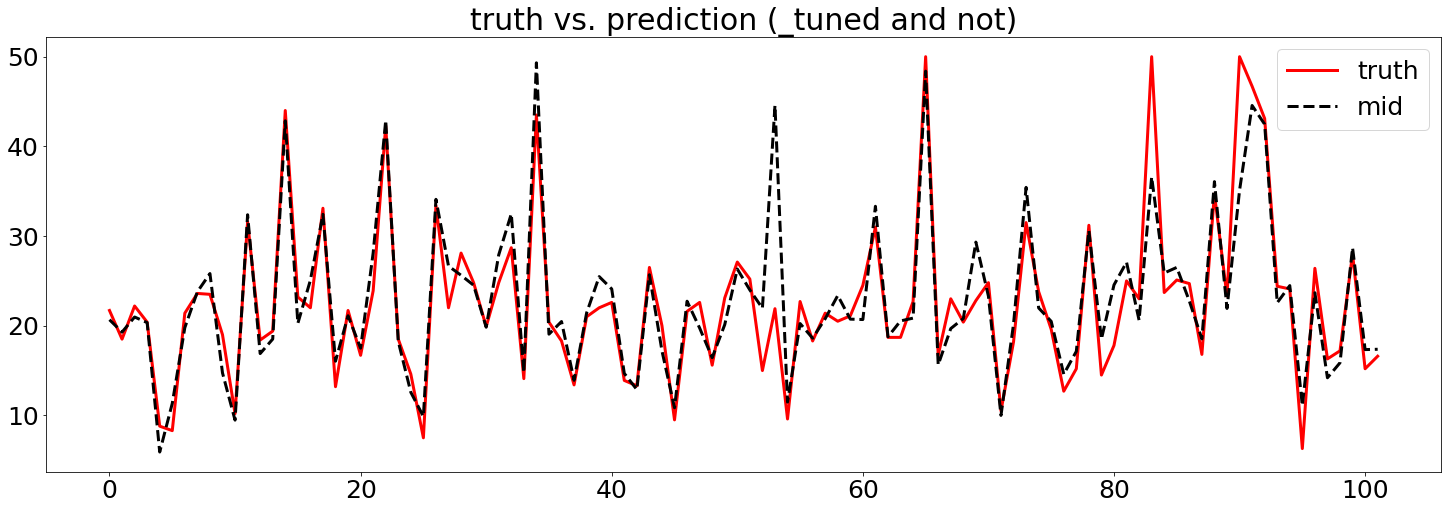

In [56]:
fig, ax = plt.subplots()

plt.title("truth vs. prediction (_tuned and not)")
dummy = range(len(predictions["mid"].values))
ax.plot(dummy, predictions["truth"].values, "-r", lw = 3, label = "truth")
#ax.plot(dummy, predictions["mid_tuned"].values, "--k", lw = 3, label = "mid_tuned")
ax.plot(dummy, predictions["mid"].values, "--k", lw = 3, label = "mid")

plt.legend()
plt.show()

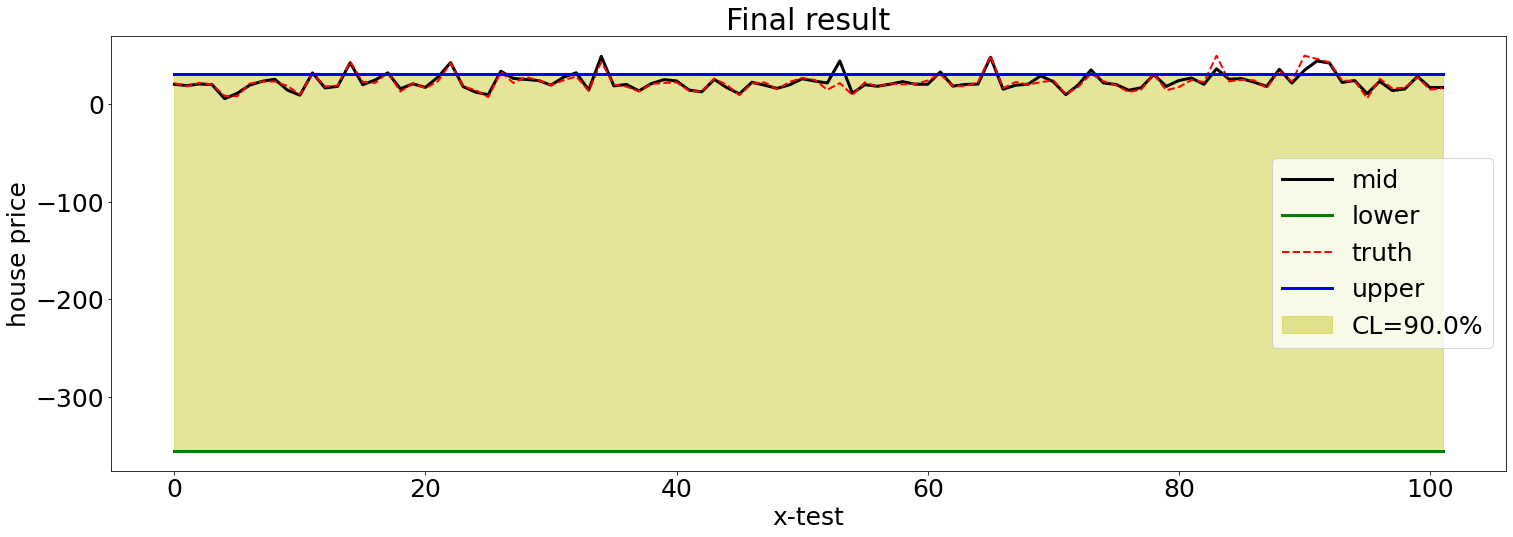

In [57]:
fig, ax = plt.subplots()

plt.title("Final result")
ax.plot(dummy, predictions["mid"].values, "-k", lw = 3, label = "mid")
ax.plot(dummy, predictions["lower"].values, "-g", lw = 3, label = "lower")
ax.plot(dummy, predictions["truth"].values, "--r", lw = 2, label = "truth")
ax.plot(dummy, predictions["upper"].values, "b-", lw = 3, label = "upper")

plt.fill_between(dummy, predictions["lower"].values, predictions["upper"].values, color = "y", alpha=0.4,
                 label='CL=' + str(CL*100)+"%")

ax.set_xlabel("x-test")
ax.set_ylabel("house price")
plt.legend()
plt.show()

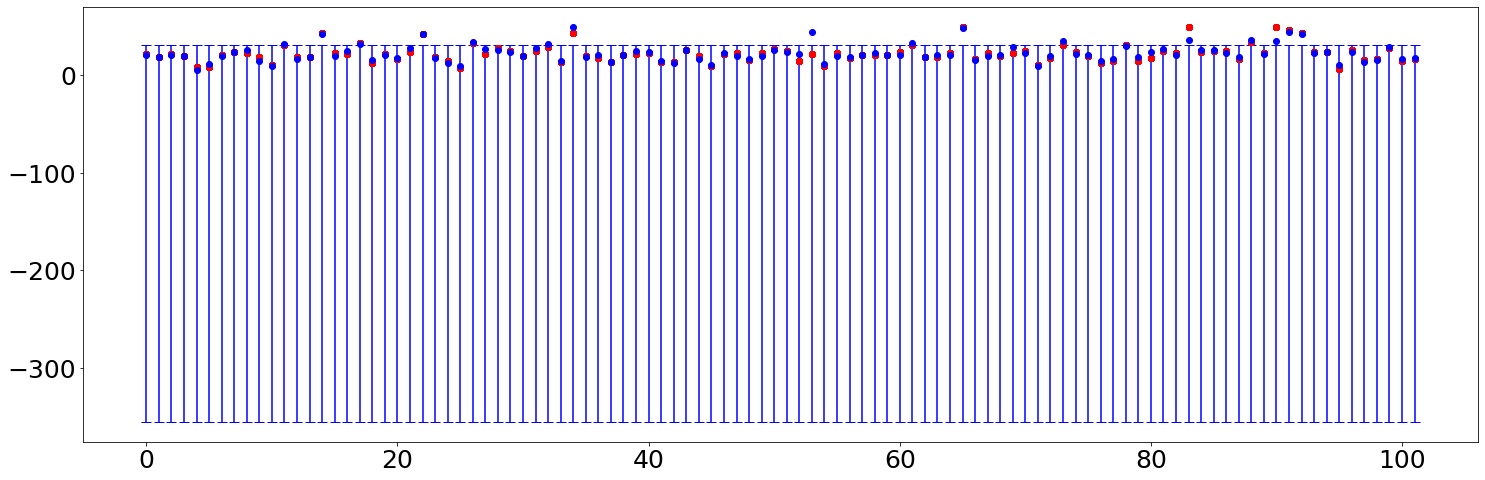

In [58]:
fig, ax = plt.subplots()

for i in range(len(predictions["ID"])):    
    ax.plot(predictions["ID"], predictions["truth"], "ro")
    mean = predictions["mid"][i]
    lower = mean - predictions["lower"][i]
    upper = predictions["upper"][i] - mean
    ax.errorbar(predictions["ID"][i], [mean], yerr=np.array([[lower, upper]]).T, fmt='bo-', 
                solid_capstyle='projecting', capsize=5)

    #ax.legend()
plt.show()

# Conclusion


- The expectile loss did not want to work!
- The model did not want to converge. I am not sure whether this depends from the small datase or an error in the way I compputed the derivative.

